# SETUP

## Constants

In [1]:
# Generating skip-grams
CONTEXT_WINDOW_SIZE = 2

# Hyperparameters
EPOCHS = 5
LR = 0.1
BATCH_SIZE = 32
EMB_DIM = 10

## Import

In [2]:
import sys
import os
from shared.constants import *

import re

from nltk import word_tokenize, sent_tokenize

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import lightning as L

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# DATA

In [3]:
with open(TXT_FILE) as f:
    text = f.read()
    text = re.sub(LINE_TO_EXCLUDE, '', text, flags=re.MULTILINE | re.IGNORECASE)

## Tokenized Corpus

In [4]:
sentences = sent_tokenize(text)
tokenized_corpus = []

for sentence in sentences:
    tokens = []
    for word in word_tokenize(sentence):
        word = word.strip(PUNCTUATION)
        if word:
            tokens.append(word)
    tokens.append('<EOS>')
    tokenized_corpus.append(tokens)

print(tokenized_corpus[:3])

[['It', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '<EOS>'], ['However', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood', 'this', 'truth', 'is', 'so', 'well', 'fixed', 'in', 'the', 'minds', 'of', 'the', 'surrounding', 'families', 'that', 'he', 'is', 'considered', 'as', 'the', 'rightful', 'property', 'of', 'some', 'one', 'or', 'other', 'of', 'their', 'daughters', '<EOS>'], ['My', 'dear', 'Mr', 'Bennet', 'said', 'his', 'lady', 'to', 'him', 'one', 'day', 'have', 'you', 'heard', 'that', 'Netherfield', 'Park', 'is', 'let', 'at', 'last', 'Mr', 'Bennet', 'replied', 'that', 'he', 'had', 'not', '<EOS>']]


## Indexed Corpus

In [5]:
# Build vocabulary
WORD2IDX = {word: idx for idx, word in enumerate(set(sum(tokenized_corpus, [])))}
IDX2WORD = {idx: word for word, idx in WORD2IDX.items()}
VOCAB_SIZE = len(WORD2IDX)
# Convert tokenized corpus to indexed corpus
indexed_corpus = [[WORD2IDX[word] for word in sentence] for sentence in tokenized_corpus]

print(indexed_corpus[0])
print(len(indexed_corpus))
print(VOCAB_SIZE)

[4878, 5571, 5178, 271, 6224, 4109, 3773, 5178, 4161, 876, 5231, 42, 3091, 5178, 3312, 4687, 2365, 5157, 5231, 3897, 3091, 5178, 4601, 6436]
4651
6762


## Skip-Gram Pairs

In [6]:
def generate_skipgrams(indexed_corpus, window_size=CONTEXT_WINDOW_SIZE): 
    data = []
    for sentence in indexed_corpus:
        for i, target in enumerate(sentence):
            window = range(max(0, i-window_size), min(len(sentence), i+window_size+1))
            context = [sentence[j] for j in window if j!=i]
            for ctx in context:
                data.append((target, ctx)) # pair every word with each word in the context
    return data

skipgram_pairs = generate_skipgrams(indexed_corpus)[:100]
print(skipgram_pairs[0])
print(len(skipgram_pairs))

(4878, 5571)
100


## Train Data

In [7]:
X_train = torch.LongTensor([pair[0] for pair in skipgram_pairs])  # target words
y_train = torch.LongTensor([pair[1] for pair in skipgram_pairs])  # context words
# nn.Embedding and nn.CrossEntropyLoss require torch.int64 (LongTensor) inputs for indexing and categorical targets.

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# MODEL

In [8]:
def save_model(model):
    path = os.path.join('models', f'skipgram_emb{EMB_DIM}_e{EPOCHS}_lr{LR}.pth')
    if os.path.exists(path):
        raise FileExistsError(f"{path} already exists.")

    hyperparameters = {
        'emb_dim': EMB_DIM,
        'epochs': EPOCHS,
        'lr': LR,
        'batch_size': BATCH_SIZE,
        'vocab_size': VOCAB_SIZE,
    }

    torch.save(
        {'model_state_dict': model.state_dict(), 'hyperparameters': hyperparameters},
        path
    )

## From Scratch

In [9]:

# class SkipGramModelFromScratch(L.LightningModule):

#     def __init__(self):
#         super().__init__()
#         L.seed_everything(seed=42)
#         self.input_to_hidden = nn.Linear(in_features=len(dataset), out_features=EMB_DIM, bias=False)
#         self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)
#         self.loss = nn.CrossEntropyLoss()

#     def forward(self, input):
#         hidden = self.input_to_hidden(input)
#         # Then we pass "hidden" to the weights we created with nn.Linear() between the hidden layer and the output.
#         output_values = self.hidden_to_output(hidden)
#         return(output_values)


#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=LR)


#     def training_step(self, batch, batch_idx):
#         input_i, label_i = batch
#         output_i = self.forward(input_i)
#         loss = self.loss(output_i, label_i)
        
#         self.log("train_loss", loss)

#         return loss

## nn.Embedding

In [10]:
class SkipGramModelEmbedding(L.LightningModule):

    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim, vocab_size)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, context_word):
        embedding = self.embeddings(context_word)
        output = self.linear(embedding)
        return output
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=LR)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)

        self.log("train_loss", loss)
        
        return loss

In [11]:
%%capture
sys.exit("Manual execution required")

modelEmbedding = SkipGramModelEmbedding(VOCAB_SIZE, EMB_DIM)
trainer = L.Trainer(max_epochs=EPOCHS)
trainer.fit(modelEmbedding, train_dataloaders=dataloader)

SystemExit: Manual execution required

In [12]:
%%capture
sys.exit("Manual execution required")

save_model(modelEmbedding)

SystemExit: Manual execution required

# DEMO

In [17]:
# Load model

checkpoint = torch.load("models/skipgram_emb10_e5_lr0.1.pth")

hyperparameters = checkpoint['hyperparameters']
model = SkipGramModelEmbedding(hyperparameters['vocab_size'], hyperparameters['emb_dim'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
def visualize_words_embedding(model):
  
  words = [
    'Elizabeth', 'Darcy', 'Bingley', 'Lydia', 'Jane', 'Collins', 'Pemberley', 
    'Meryton', 'Lady', 'Wickham', 'marriage', 'love', 'prejudice', 'fortune', 
    'accomplished', 'pride', 'sense', 'character', 'family', 'society',
    'husband', 'wife', 'man', 'woman', 'summer', 'spring', 'winter'
  ]
  
  indices = [WORD2IDX[word] for word in words]
  embeddings = model.embeddings.weight.data[indices]

  tsne = TSNE(n_components=2, perplexity=20, random_state=42) # 2d t-SNE
  embeddings_2d = tsne.fit_transform(embeddings)

  colors = sns.husl_palette(n_colors = len(words))
  plt.figure(figsize=(10, 10))
  for i, word in enumerate(words):
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=colors)
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
  
  plt.show();

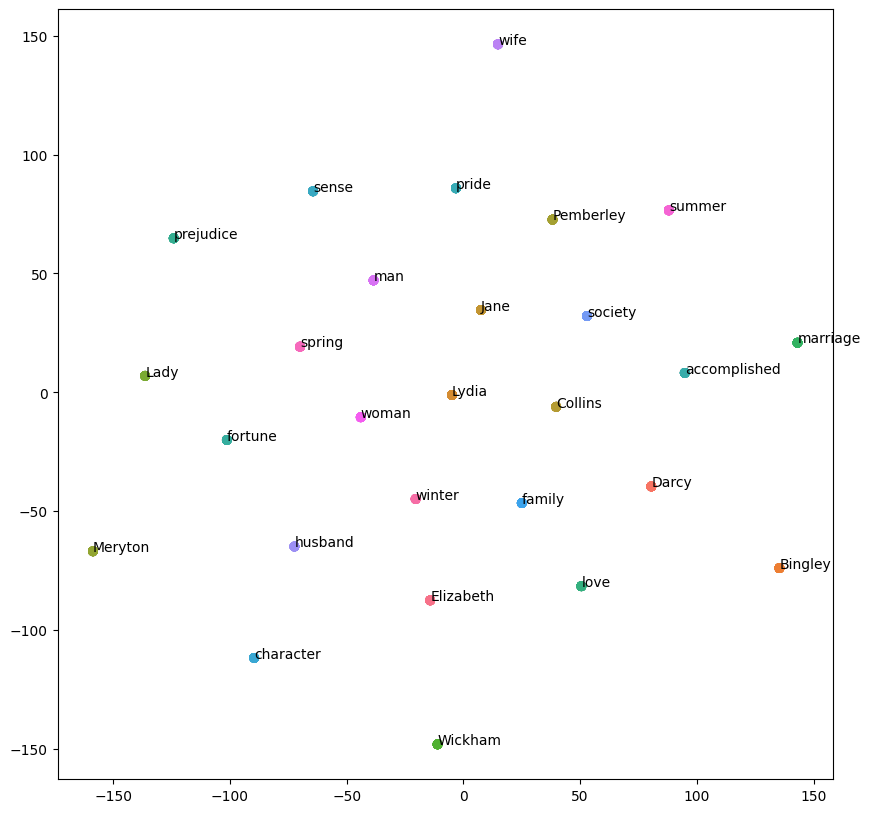

In [19]:
visualize_words_embedding(model)